## **Exercise for WWL Package with subset of 529E**

In [1]:
# import library
import sys
sys.path.append('./WWL/src')
from wwl import wwl
import igraph as ig

import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon, Point, LineString
from shapely.ops import unary_union
import numpy as np
from scipy.spatial import Voronoi
import matplotlib.pyplot as plt
import networkx as nx
from scipy.stats import wasserstein_distance
import ot

In [2]:
# placing points on the vertices where an edge changes direction, constructing edges between vertices
def sample_points_at_vertices(shapefile_path):
    gdf = gpd.read_file(shapefile_path)
    all_vertex_points = []
    all_edges = []

    for idx, row in gdf.iterrows():
        geom = row.geometry # extracts the geometry (i.e., building footprint) from the row in the gdf

        # skip any rows without geometry or with a geometry that is not a polygon or multipolygon, null geometries
        if geom is None or not isinstance(geom, (Polygon, MultiPolygon)):
            print(idx)
            print(geom)
            continue

        # if the geometry is a multipolygon, merge them into a single polygon
        if isinstance(geom, MultiPolygon):
            geom = unary_union(geom)

        exterior_coords = list(geom.exterior.coords) # get the coordinates of the outer boundary of the polygon, in a sequence of (x,y) tuples
        coords = exterior_coords[:-1]
        vertex_points = [Point(xy) for xy in exterior_coords[:-1]]  # convert each (x,y) coordinate into a Point object, exclude the last coordinate since it duplicates the first (to close the polygon)
        all_vertex_points.extend(vertex_points) # add all the Point objects of a polygon to the list all_vertex_points

        # Create edges between consecutive vertices
        edges = [LineString([coords[i], coords[i + 1]]) for i in range(len(coords) - 1)]
        # Add edge between the last and first to close the polygon
        edges.append(LineString([coords[-1], coords[0]]))

        all_edges.extend(edges)

    # Return GeoDataFrames for points and edges
    points_gdf = gpd.GeoDataFrame(geometry=all_vertex_points, crs=gdf.crs)
    edges_gdf = gpd.GeoDataFrame(geometry=all_edges, crs=gdf.crs)

    return gdf, points_gdf, edges_gdf

In [3]:
import skgeom as sg
from skgeom.draw import draw

In [4]:
def draw_skeleton(polygon, skeleton, show_time=False):
    draw(polygon)

    for h in skeleton.halfedges:
        if h.is_bisector:
            p1 = h.vertex.point
            p2 = h.opposite.vertex.point
            plt.plot([p1.x(), p2.x()], [p1.y(), p2.y()], 'r-', lw=2)

    if show_time:
        for v in skeleton.vertices:
            plt.gcf().gca().add_artist(plt.Circle(
                (v.point.x(), v.point.y()),
                v.time, color='blue', fill=False))

In [5]:
def draw_all_skeletons(polygon, all_skeletons, show_time=False, figsize=(24,24)):
    plt.figure(figsize=figsize)
    draw(polygon, line_width=0.5)
    
    for item in all_skeletons:

        if item is None:
            continue
        
        for h in item.halfedges:
            if h.is_bisector:
                p1 = h.vertex.point
                p2 = h.opposite.vertex.point
                plt.plot([p1.x(), p2.x()], [p1.y(), p2.y()], 'r-', lw=0.5)

        if show_time:
            for v in skeleton.vertices:
                plt.gcf().gca().add_artist(plt.Circle(
                    (v.point.x(), v.point.y()),
                    v.time, color='blue', fill=False))
    return plt

In [6]:
### function #1: Extract poitns from one polygon
def pts_to_skeleton(geom):
    '''
    This function extracts points from a geometry, converts them into a polygon, and draws the skeleton of a geometry. It returns a skeleton graph of a geometry
    '''
    points = []
    for x, y in geom.boundary.coords[:-1]:
        points.append(sg.Point2(x,y))
    points_to_poly = points[::-1] # make sure it is counter-clockwise
    poly_to_skel = sg.Polygon(points_to_poly)
    skeleton = sg.skeleton.create_interior_straight_skeleton(poly_to_skel)
    return skeleton


### function #2: Convert skeleton graphs to networkx graphs
def skeleton2networkx(skeleton):
    geom_vertices = list(skeleton.vertices)
    geom_edges = list(skeleton.halfedges)

    # create an empty graph with no nodes and no edges
    G=nx.Graph()

    # grow undirected (since it adds up from both direction) graph G by adding edge, done by specifying the vertex id at two ends to determine the edge
    for item in geom_edges:
        if item.is_bisector:
            p1 = item.vertex.id # vertex id
            p2 = item.opposite.vertex.id
            G.add_edge(p1, p2)
    #nx.draw(G, with_labels=True)
    return G

In [7]:
# load building footprint for cleaning - ext boundaries
sim_buildings_ext_gdf, sim_points_ext_gdf, sim_edges_ext_gdf = sample_points_at_vertices("./data/output/sim_buildings_ext_boundary_diss.shp")

In [8]:
sim_buildings_ext_boundary_diss = gpd.read_file("./data/output/sim_buildings_ext_boundary_diss.shp")

In [9]:
ske_2 = pts_to_skeleton(sim_buildings_ext_gdf.geometry[2])
gs_2 = skeleton2networkx(ske_2)

ske_151 = pts_to_skeleton(sim_buildings_ext_gdf.geometry[151])
gs_151 = skeleton2networkx(ske_151)

ske_155 = pts_to_skeleton(sim_buildings_ext_gdf.geometry[155])
gs_155 = skeleton2networkx(ske_155)

ske_183 = pts_to_skeleton(sim_buildings_ext_gdf.geometry[183])
gs_183 = skeleton2networkx(ske_183)

ske_221 = pts_to_skeleton(sim_buildings_ext_gdf.geometry[221])
gs_221 = skeleton2networkx(ske_221)

ske_224 = pts_to_skeleton(sim_buildings_ext_gdf.geometry[224])
gs_224 = skeleton2networkx(ske_224)

In [ ]:
#nx.draw(gs_2)
draw

In [ ]:
nx.draw(gs_151, with_labels=True)

In [ ]:
nx.draw(gs_155)

In [ ]:
nx.draw(gs_183)

In [ ]:
nx.draw(gs_221)

In [ ]:
nx.draw(gs_224)

**Comptue the weight/distance of vertices for each medial axis**

In [10]:
# combine all skeletons
combined_ske = [ske_2,ske_151,ske_155,ske_183,ske_221,ske_224]
#combined_ske = [ske_151,ske_155]

combined_ske

In [11]:
import math

# ## 2
# # obtain vertices
# vertices2 = list(ske_2.vertices)
# # obtain edges
# edges2 = list(ske_2.halfedges)

# weights = {}
# for edge in ske_2.halfedges:
#     if edge.is_bisector:
#         u1_pt = edge.vertex.point
#         u2_pt = edge.opposite.vertex.point
#         u1_vertex = edge.vertex
#         u2_vertex = edge.opposite.vertex
#         d_u1u2 = math.sqrt((u2_pt.x()-u1_pt.x())**2 + (u2_pt.y()-u1_pt.y())**2)
#         weights[(u1_vertex.id, u2_vertex.id)] = d_u1u2

# weights
                

# to obtain edge weights for all skeletons

all_weights = []
for skeleton in combined_ske:
    weights = {}
    for edge in skeleton.halfedges:
        if edge.is_bisector:
            u1_pt = edge.vertex.point
            u2_pt = edge.opposite.vertex.point
            u1_vertex = edge.vertex
            u2_vertex = edge.opposite.vertex
            d_u1u2 = math.sqrt((u2_pt.x()-u1_pt.x())**2 + (u2_pt.y()-u1_pt.y())**2)
            weights[(u1_vertex.id, u2_vertex.id)] = d_u1u2 
    all_weights.append(weights)


all_weights

[{(8, 0): 9.592372510200464,
  (0, 8): 9.592372510200464,
  (8, 1): 9.477622524738061,
  (1, 8): 9.477622524738061,
  (9, 2): 9.828968775352473,
  (2, 9): 9.828968775352473,
  (9, 3): 9.590794156831556,
  (3, 9): 9.590794156831556,
  (9, 8): 61.051472859698656,
  (8, 9): 61.051472859698656},
 {(8, 0): 10.825321437569102,
  (0, 8): 10.825321437569102,
  (9, 1): 11.216861761842821,
  (1, 9): 11.216861761842821,
  (9, 2): 11.344539218341213,
  (2, 9): 11.344539218341213,
  (8, 3): 10.988968939013212,
  (3, 8): 10.988968939013212,
  (9, 8): 168.03575428291714,
  (8, 9): 168.03575428291714},
 {(16, 0): 3.3279101195897405,
  (0, 16): 3.3279101195897405,
  (23, 1): 5.235058469565962,
  (1, 23): 5.235058469565962,
  (20, 2): 5.155705668105134,
  (2, 20): 5.155705668105134,
  (25, 3): 7.13710399428437,
  (3, 25): 7.13710399428437,
  (24, 4): 7.227778658082617,
  (4, 24): 7.227778658082617,
  (24, 5): 7.17248614836995,
  (5, 24): 7.17248614836995,
  (17, 6): 3.3083565477087227,
  (6, 17): 3.3083

**Node featuers**

According to [Duong et al. (2023)](https://doi.org/10.1145/3615900.3628790), node features denotes the radius of the corresponding node of the medial axis transform for all $v \in V$.

In [ ]:
# print(len(list(ske_155.vertices)))
# print(list(ske_155.vertices)[12].time)

**Weisfeiler-Lehman propagation**

First, convert networkx graphs to igraph graphs. Refer to documentation [here](https://networkx.org/documentation/stable/auto_examples/external/plot_igraph.html).

In [12]:
# from networkx to igraph
ig_2 = ig.Graph.from_networkx(gs_2)
ig_151 = ig.Graph.from_networkx(gs_151)
ig_155 = ig.Graph.from_networkx(gs_155)
ig_183 = ig.Graph.from_networkx(gs_183)
ig_221 = ig.Graph.from_networkx(gs_221)
ig_224 = ig.Graph.from_networkx(gs_224)

In [ ]:
# visual_style = {}
# visual_style["vertex_size"] = 6
# visual_style["vertex_label"] = ig_151.vs["label"]
# layout = ig_151.layout("kk")
# ig.plot(ig_151,layout=layout)

In [ ]:
# for vertex in gs_151:
#     print(vertex)

In [ ]:
# for vertex in ig_151.vs:
#     print(vertex["_nx_name"])

In [13]:
ig_graphs = [ig_2, ig_151, ig_155, ig_183, ig_221, ig_224]
#ig_graphs = [ig_151, ig_155]
ig_graphs

In [14]:
# get the length of graphs to build the matrix of node_features
len(list(ig_graphs))

6

In [15]:
# get the radius of medial axis of each node from each graph

# # 2
# nodes_ls_2 = []

# for i in list(ske_2.vertices):
#     nodes_ls_2.append([i.time])

# print(f"2: {nodes_ls_2}")
# ---
nodes_ls_2_dict = {}
for i in list(ske_2.vertices):
    nodes_ls_2_dict[i.id] = i.time
#print(f"2 dict: {nodes_ls_2_dict}")

# 151
# nodes_ls_151 = []

# for i in list(ske_151.vertices):
#     nodes_ls_151.append([i.time])

# print(f"151: {nodes_ls_151}")
# ---
nodes_ls_151_dict = {}
for i in list(ske_151.vertices):
    nodes_ls_151_dict[i.id] = i.time
#print(f"151 dict: {nodes_ls_151_dict}")

# 155
# nodes_ls_155 = []

# for i in list(ske_155.vertices):
#     nodes_ls_155.append([i.time])

# print(f"155: {nodes_ls_155}")
# ---
nodes_ls_155_dict = {}
for i in list(ske_155.vertices):
    nodes_ls_155_dict[i.id] = i.time
#print(f"155 dict: {nodes_ls_155_dict}")

# # 183
# nodes_ls_183 = []

# for i in list(ske_183.vertices):
#     nodes_ls_183.append([i.time])

# print(f"183:{nodes_ls_183}")
# ---
nodes_ls_183_dict = {}
for i in list(ske_183.vertices):
    nodes_ls_183_dict[i.id] = i.time
#print(f"183 dict: {nodes_ls_183_dict}")


# # 221
# nodes_ls_221 = []

# for i in list(ske_221.vertices):
#     nodes_ls_221.append([i.time])

# print(f"221:{nodes_ls_221}")
# ---
nodes_ls_221_dict = {}
for i in list(ske_221.vertices):
    nodes_ls_221_dict[i.id] = i.time
#print(f"221 dict: {nodes_ls_221_dict}")

# # 224
# nodes_ls_224 = []

# for i in list(ske_224.vertices):
#     nodes_ls_224.append([i.time])

# print(f"224:{nodes_ls_224}")
# ---
nodes_ls_224_dict = {}
for i in list(ske_224.vertices):
    nodes_ls_224_dict[i.id] = i.time
#print(f"224 dict: {nodes_ls_224_dict}")

# nodes_ls = [nodes_ls_2, nodes_ls_151, nodes_ls_155, nodes_ls_183, nodes_ls_221, nodes_ls_224]
# nodes_ls = [nodes_ls_151, nodes_ls_155]
# nodes_ls
nodes_ls_dict = [nodes_ls_2_dict, nodes_ls_151_dict, nodes_ls_155_dict, nodes_ls_183_dict, nodes_ls_221_dict, nodes_ls_224_dict]
nodes_ls_dict

[{0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 8: 6.747976774744137, 9: 6.858177803181223},
 {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 8: 7.717659342542857, 9: 7.970279119009592},
 {0: 0.0,
  1: 0.0,
  2: 0.0,
  3: 0.0,
  4: 0.0,
  5: 0.0,
  6: 0.0,
  7: 0.0,
  16: 2.3614898254273764,
  17: 2.4022004055480504,
  20: 3.6962269386643727,
  23: 3.7108423678850366,
  24: 5.103631623907486,
  25: 5.108941533920166},
 {0: 0.0,
  1: 0.0,
  2: 0.0,
  3: 0.0,
  4: 0.0,
  5: 0.0,
  6: 0.0,
  7: 0.0,
  16: 2.3371013458572967,
  17: 2.373681225754804,
  20: 3.2312896833802536,
  21: 3.2363647602397236,
  24: 5.060018340113934,
  25: 5.065319324913257},
 {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 8: 4.888695302487665, 9: 4.893198549951605},
 {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 8: 4.911331003065985, 9: 4.917286909022391}]

In [ ]:
# get the max length of the number of nodes in the graphs to build the matrix for node_features
# len(nodes_ls)

# length_of_vertices = [len(a) for a in nodes_ls]

# print(max(length_of_vertices))

In [ ]:
# node_feature_m = np.zeros((len(list(ig_graphs)),max(length_of_vertices)))
# node_feature_m

# for rowIDs, rows in enumerate(node_feature_m):
#     for colIDs, cols in enumerate(rows):
#         if len(nodes_ls[rowIDs]) > colIDs:
#             node_feature_m[rowIDs, colIDs] = nodes_ls[rowIDs][colIDs] # copying the corresponding row and col into node_feature_m

# print(node_feature_m)

In [ ]:
# a = np.ones((3, 1))
# b = np.zeros((3, 1))
# np.concatenate([a, b], axis=1)

In [16]:
# compute the kernel
kernel_matrix = wwl(ig_graphs,node_features=nodes_ls_dict, edge_weight=all_weights, num_iterations=4)

INFO:root:Continuous node features provided, using CONTINUOUS propagation scheme.


{(8, 0): 9.592372510200464, (0, 8): 9.592372510200464, (8, 1): 9.477622524738061, (1, 8): 9.477622524738061, (9, 2): 9.828968775352473, (2, 9): 9.828968775352473, (9, 3): 9.590794156831556, (3, 9): 9.590794156831556, (9, 8): 61.051472859698656, (8, 9): 61.051472859698656}
{(8, 0): 9.592372510200464, (0, 8): 9.592372510200464, (8, 1): 9.477622524738061, (1, 8): 9.477622524738061, (9, 2): 9.828968775352473, (2, 9): 9.828968775352473, (9, 3): 9.590794156831556, (3, 9): 9.590794156831556, (9, 8): 61.051472859698656, (8, 9): 61.051472859698656}
{(8, 0): 9.592372510200464, (0, 8): 9.592372510200464, (8, 1): 9.477622524738061, (1, 8): 9.477622524738061, (9, 2): 9.828968775352473, (2, 9): 9.828968775352473, (9, 3): 9.590794156831556, (3, 9): 9.590794156831556, (9, 8): 61.051472859698656, (8, 9): 61.051472859698656}
{(8, 0): 9.592372510200464, (0, 8): 9.592372510200464, (8, 1): 9.477622524738061, (1, 8): 9.477622524738061, (9, 2): 9.828968775352473, (2, 9): 9.828968775352473, (9, 3): 9.59079415

In [17]:
kernel_matrix

array([[1.        , 0.3921624 , 0.14393552, 0.13896654, 0.33201586,
        0.33223365],
       [0.3921624 , 1.        , 0.12699999, 0.11896124, 0.18697391,
        0.18709656],
       [0.14393552, 0.12699999, 1.        , 0.79703884, 0.18403118,
        0.18391054],
       [0.13896654, 0.11896124, 0.79703884, 1.        , 0.17767801,
        0.17756154],
       [0.33201586, 0.18697391, 0.18403118, 0.17767801, 1.        ,
        0.97417874],
       [0.33223365, 0.18709656, 0.18391054, 0.17756154, 0.97417874,
        1.        ]])

The original design of the `wwl()` function from the authors assumes graphs of different sizes (different number of nodes), but the bug here requires graphs with the same number of nodes, possibly due to the changes of API in `numpy`...however, this has been fixed according to the issue [here](https://github.com/BorgwardtLab/WWL/issues/7). The reason this issue occurred is that the update wasn't made to `pip install wwl`. But after cloning the GitHub repository and installing the package locally, it eliminated the error below:

**Error #1: Bugs from numpy version**
```
File ~/CURA/2D_footprint_clustering/./WWL/src/wwl/propagation_scheme.py:162, in ContinuousWeisfeilerLehman._preprocess_graphs(self, X)
    157 # By default, keep degree or label as features, if other features shall
    158 # to be used (e.g. the one from the TU Dortmund website), 
    159 # provide them to the fit_transform function.
    161 n_nodes = np.asarray(n_nodes)
--> 162 node_features = np.asarray(node_features)
    164 return node_features, adj_mat, n_nodes

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (79,) + inhomogeneous part.
```
</br>

Then, now a different error occurred:

**Error #2**

```
File ~/CURA/2D_footprint_clustering/./WWL/src/wwl/propagation_scheme.py:192, in ContinuousWeisfeilerLehman.fit_transform(self, X, node_features, num_iterations)
    190 node_features_data = scale(np.concatenate(node_features, axis=0), axis = 0)
    191 splits_idx = np.cumsum(n_nodes).astype(int)
--> 192 node_features_split = np.vsplit(node_features_data,splits_idx)		
    193 node_features = node_features_split[:-1]
    195 # Generate the label sequences for h iterations

File ~/.venv/lib/python3.10/site-packages/numpy/lib/_shape_base_impl.py:1007, in vsplit(ary, indices_or_sections)
    959 """
    960 Split an array into multiple sub-arrays vertically (row-wise).
    961 
   (...)
   1004 
   1005 """
   1006 if _nx.ndim(ary) < 2:
-> 1007     raise ValueError('vsplit only works on arrays of 2 or more dimensions')
   1008 return split(ary, indices_or_sections, 0)

ValueError: vsplit only works on arrays of 2 or more dimensions
```

The authors use `node_features_split = np.vsplit(node_features_data,splits_idx)` where `np.vsplit` is meant for 2D or arrays, but the authors concatenate the node features before running the `np.vsplit` (as indicated below), so not quite sure why the authors chose to use `np.vsplit` instead of just `np.split`

```
        node_features_data = scale(np.concatenate(node_features, axis=0), axis = 0)
        splits_idx = np.cumsum(n_nodes).astype(int)
        print(node_features_data,splits_idx)
        node_features_split = np.vsplit(node_features_data,splits_idx)		
        node_features = node_features_split[:-1]
```


**Error #3**

```
File ~/CURA/2D_footprint_clustering/./WWL/src/wwl/propagation_scheme.py:214, in ContinuousWeisfeilerLehman.fit_transform(self, X, node_features, num_iterations)
    211             graph_feat.append(graph_feat_cur)
    213     print(graph_feat)
--> 214     self._label_sequences.append(np.concatenate(graph_feat, axis = 1))
    215 return self._label_sequences

AxisError: axis 1 is out of bounds for array of dimension 1
```

Based on two clues below, we know that `node_features` has to be a list of 2D array:

`node_features_split = np.vsplit(node_features_data,splits_idx)`
`self._label_sequences.append(np.concatenate(graph_feat, axis = 1))`

So when creating `node_featues` in **input 13**, append the `vertices.time` as a list. Then when combining all graphs together, they will become a list of 2D list.

To edit the function and account for spatial attributes by defining weights based on Euclidean distance between nodes, refer [here](https://github.com/BorgwardtLab/WWL/blob/107a8dfe3d97d8996753dbdc695f4577514cacbf/src/wwl/propagation_scheme.py#L209).

**Spectral Clustering**

*(Simple) Adjacency Matric*

In [ ]:
# construct adjacency matrix from the distance matrix
# based on the lecture video, in A matrix, it should be 0 in the diagonal
# 1 - HV_529E_dist_m will create a diagonal with the value of 1, np.eye() is to subtract the diagonal by 1 to get 0
# A = 1-kernel_matrix - np.eye(kernel_matrix.shape[0])
# A

In [18]:
# construct laplacian matrix, L = D - A
# compute D
D = np.diag(kernel_matrix.sum(axis=1))
print(D)

[[2.33931396 0.         0.         0.         0.         0.        ]
 [0.         2.0121941  0.         0.         0.         0.        ]
 [0.         0.         2.43591606 0.         0.         0.        ]
 [0.         0.         0.         2.41020617 0.         0.        ]
 [0.         0.         0.         0.         2.85487769 0.        ]
 [0.         0.         0.         0.         0.         2.85498102]]


**Laplacian Matrix**

In [19]:
# compute L
L = D - kernel_matrix
print(L)

[[ 1.33931396 -0.3921624  -0.14393552 -0.13896654 -0.33201586 -0.33223365]
 [-0.3921624   1.0121941  -0.12699999 -0.11896124 -0.18697391 -0.18709656]
 [-0.14393552 -0.12699999  1.43591606 -0.79703884 -0.18403118 -0.18391054]
 [-0.13896654 -0.11896124 -0.79703884  1.41020617 -0.17767801 -0.17756154]
 [-0.33201586 -0.18697391 -0.18403118 -0.17767801  1.85487769 -0.97417874]
 [-0.33223365 -0.18709656 -0.18391054 -0.17756154 -0.97417874  1.85498102]]


**K-mean clustering**

In [20]:
from scipy.sparse import csgraph
from scipy.sparse.linalg import eigsh

In [21]:
def eigenDecomposition(A, plot = True, topK = 5):
    """
    :param A: Affinity matrix
    :param plot: plots the sorted eigen values for visual inspection
    :return A tuple containing:
    - the optimal number of clusters by eigengap heuristic
    - all eigen values
    - all eigen vectors
    
    This method performs the eigen decomposition on a given affinity matrix,
    following the steps recommended in the paper:
    1. Construct the normalized affinity matrix: L = D−1/2ADˆ −1/2.
    2. Find the eigenvalues and their associated eigen vectors
    3. Identify the maximum gap which corresponds to the number of clusters
    by eigengap heuristic
    
    References:
    https://papers.nips.cc/paper/2619-self-tuning-spectral-clustering.pdf
    http://www.kyb.mpg.de/fileadmin/user_upload/files/publications/attachments/Luxburg07_tutorial_4488%5b0%5d.pdf
    """
    L = csgraph.laplacian(A, normed=True)
    n_components = A.shape[0]
    
    # LM parameter : Eigenvalues with largest magnitude (eigs, eigsh), that is, largest eigenvalues in 
    # the euclidean norm of complex numbers.
#     eigenvalues, eigenvectors = eigsh(L, k=n_components, which="LM", sigma=1.0, maxiter=5000)
    eigenvalues, eigenvectors = eigsh(L, k=n_components, which="LM", sigma=1.0, maxiter=5000)
    
    if plot:
        plt.title('Largest eigen values of input matrix')
        plt.scatter(np.arange(len(eigenvalues)), eigenvalues)
        plt.grid()
        
    # Identify the optimal number of clusters as the index corresponding
    # to the larger gap between eigen values
    index_largest_gap = np.argsort(np.diff(eigenvalues))[::-1][:topK]
    nb_clusters = index_largest_gap + 1
        
    return nb_clusters, eigenvalues, eigenvectors

Optimal number of clusters: [1 3 2 4 5]


/tmp/ipykernel_130346/1593121976.py:27: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  eigenvalues, eigenvectors = eigsh(L, k=n_components, which="LM", sigma=1.0, maxiter=5000)


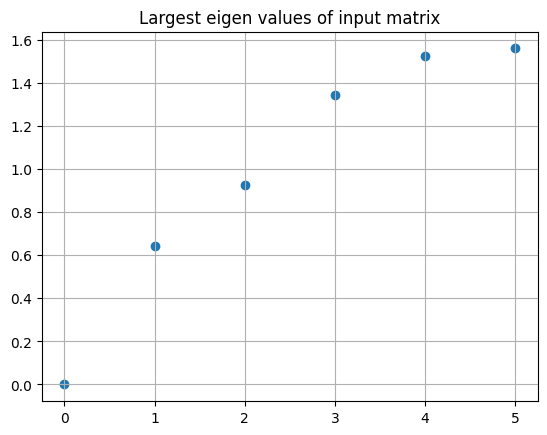

In [22]:
k, _, _ = eigenDecomposition(kernel_matrix)
print(f"Optimal number of clusters: {k}")

In [23]:
from sklearn.cluster import SpectralClustering

In [24]:
# subset from sim_buildings_ext_gdf
sub_gdf = sim_buildings_ext_gdf.iloc[[2,151,155,183,221,224]]
sub_gdf

,blockID,stories,materials,geometry
2,1869,None,concrete and cinder block,"POLYGON ((-9233783.642 4859312.213, -9233782.5..."
151,760b,None,concrete and cinder block,"POLYGON ((-9233404.567 4859007.961, -9233587.9..."
155,791,1.5,frame or wood,"POLYGON ((-9233395.35 4858922.309, -9233393.44..."
183,827_b,1.5,frame or wood,"POLYGON ((-9233402.605 4858822.141, -9233400.8..."
221,873,1.5,frame or wood,"POLYGON ((-9233608.992 4858668.227, -9233599.2..."
224,879,1.5,frame or wood,"POLYGON ((-9233612.432 4858648.128, -9233600.7..."


- *n*=2

In [25]:
# n = 2
clsutering_2 = SpectralClustering(n_clusters=2, affinity='precomputed', assign_labels='kmeans', random_state=0).fit(kernel_matrix)
y_pred_2 = clsutering_2.labels_.astype(int)

In [26]:
sub_gdf['cluster_2'] = y_pred_2
sub_gdf['cluster_2'] = sub_gdf['cluster_2'].astype('category') # Make the column categorical
sub_gdf

/home/summerha/.venv/lib/python3.10/site-packages/geopandas/geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,blockID,stories,materials,geometry,cluster_2
2,1869,None,concrete and cinder block,"POLYGON ((-9233783.642 4859312.213, -9233782.5...",1
151,760b,None,concrete and cinder block,"POLYGON ((-9233404.567 4859007.961, -9233587.9...",1
155,791,1.5,frame or wood,"POLYGON ((-9233395.35 4858922.309, -9233393.44...",0
183,827_b,1.5,frame or wood,"POLYGON ((-9233402.605 4858822.141, -9233400.8...",0
221,873,1.5,frame or wood,"POLYGON ((-9233608.992 4858668.227, -9233599.2...",1
224,879,1.5,frame or wood,"POLYGON ((-9233612.432 4858648.128, -9233600.7...",1


Text(0.5, 1.0, 'Building Clusters (k=2)')

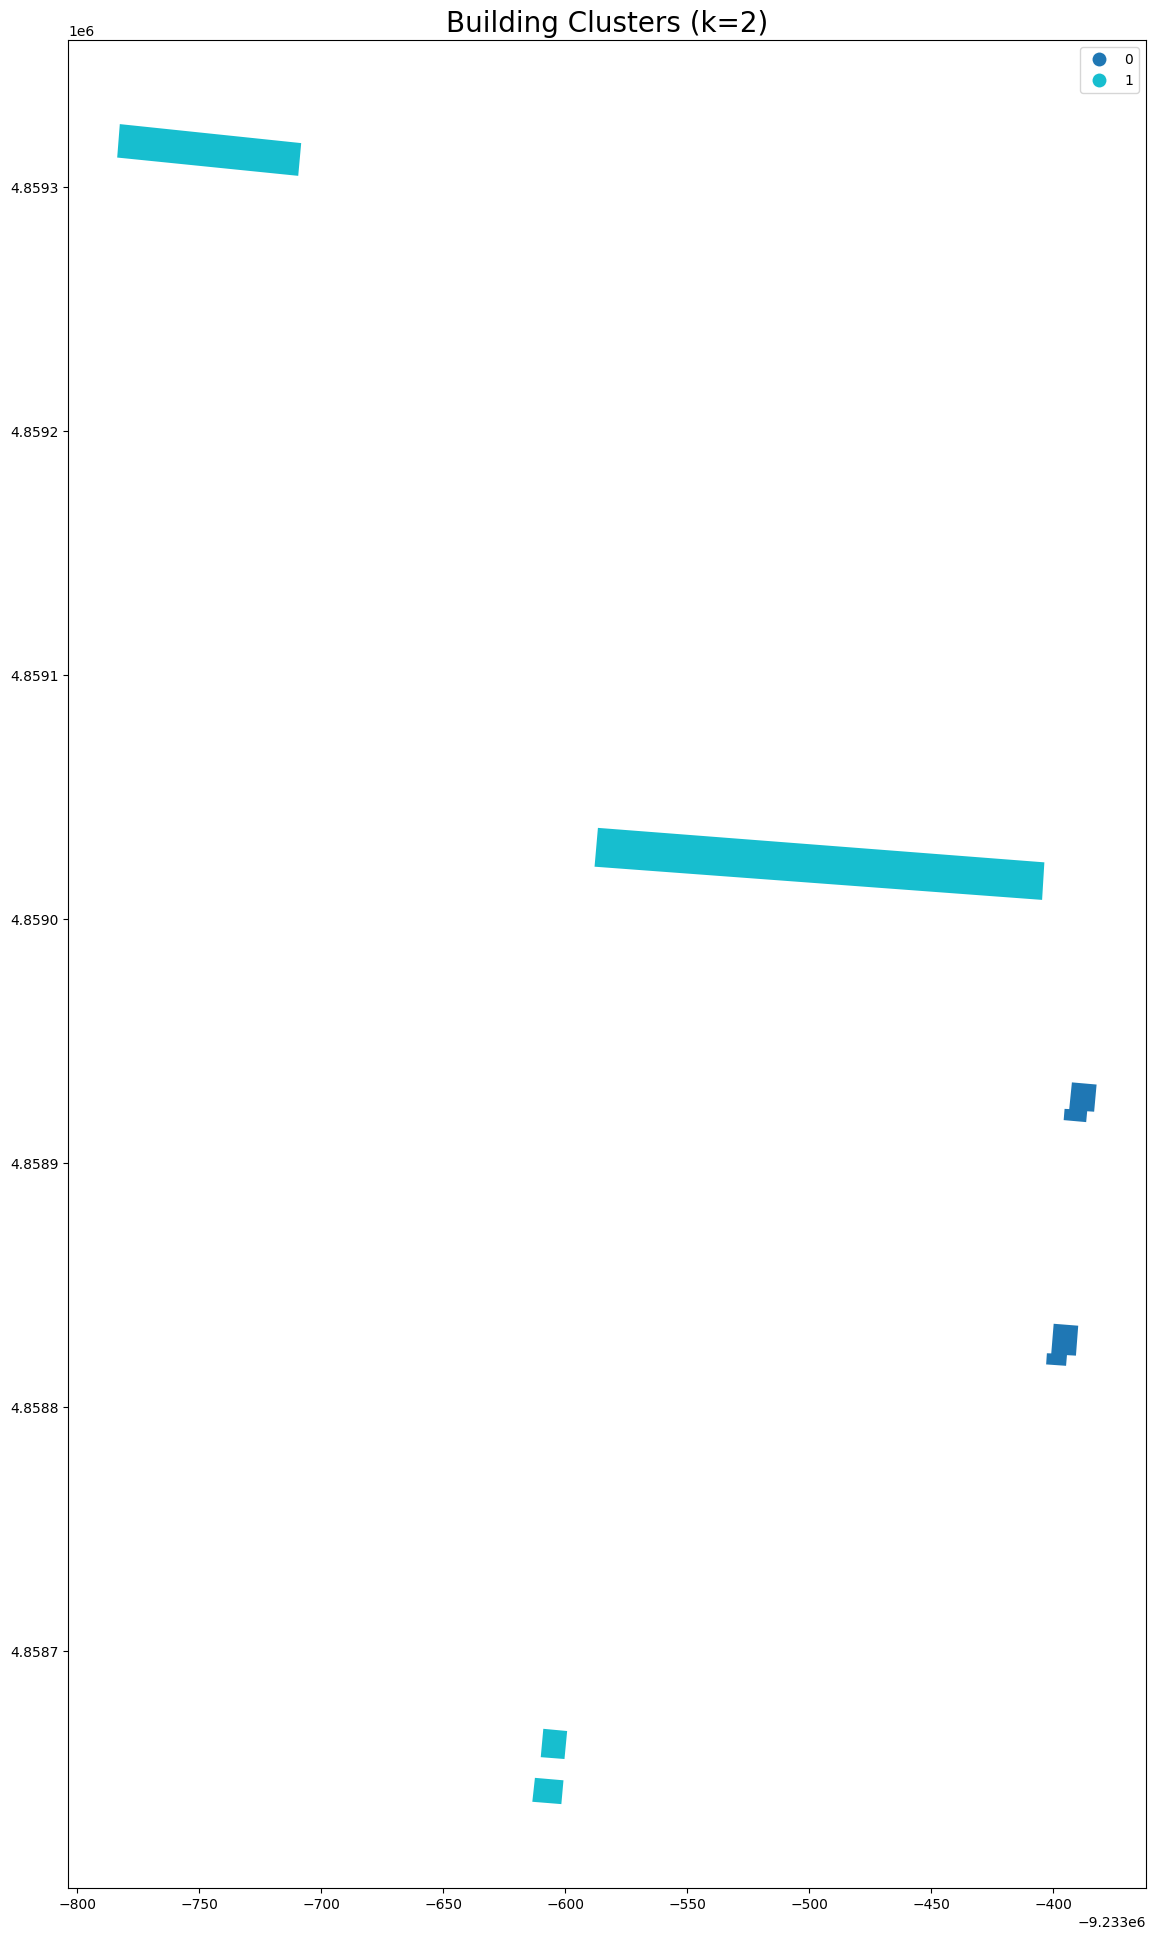

In [27]:
sub_gdf.plot(column='cluster_2', cmap='tab10', legend=True, figsize=(24,24))
plt.title("Building Clusters (k=2)", fontsize=20)

- *n*=3

In [28]:
# n = 3
clsutering_3 = SpectralClustering(n_clusters=3, affinity='precomputed', assign_labels='kmeans', random_state=0).fit(kernel_matrix)
y_pred_3 = clsutering_3.labels_.astype(int)

In [29]:
sub_gdf['cluster_3'] = y_pred_3
sub_gdf['cluster_3'] = sub_gdf['cluster_3'].astype('category') # Make the column categorical
sub_gdf

/home/summerha/.venv/lib/python3.10/site-packages/geopandas/geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,blockID,stories,materials,geometry,cluster_2,cluster_3
2,1869,None,concrete and cinder block,"POLYGON ((-9233783.642 4859312.213, -9233782.5...",1,1
151,760b,None,concrete and cinder block,"POLYGON ((-9233404.567 4859007.961, -9233587.9...",1,1
155,791,1.5,frame or wood,"POLYGON ((-9233395.35 4858922.309, -9233393.44...",0,0
183,827_b,1.5,frame or wood,"POLYGON ((-9233402.605 4858822.141, -9233400.8...",0,0
221,873,1.5,frame or wood,"POLYGON ((-9233608.992 4858668.227, -9233599.2...",1,2
224,879,1.5,frame or wood,"POLYGON ((-9233612.432 4858648.128, -9233600.7...",1,2


Text(0.5, 1.0, 'Building Clusters (k=3)')

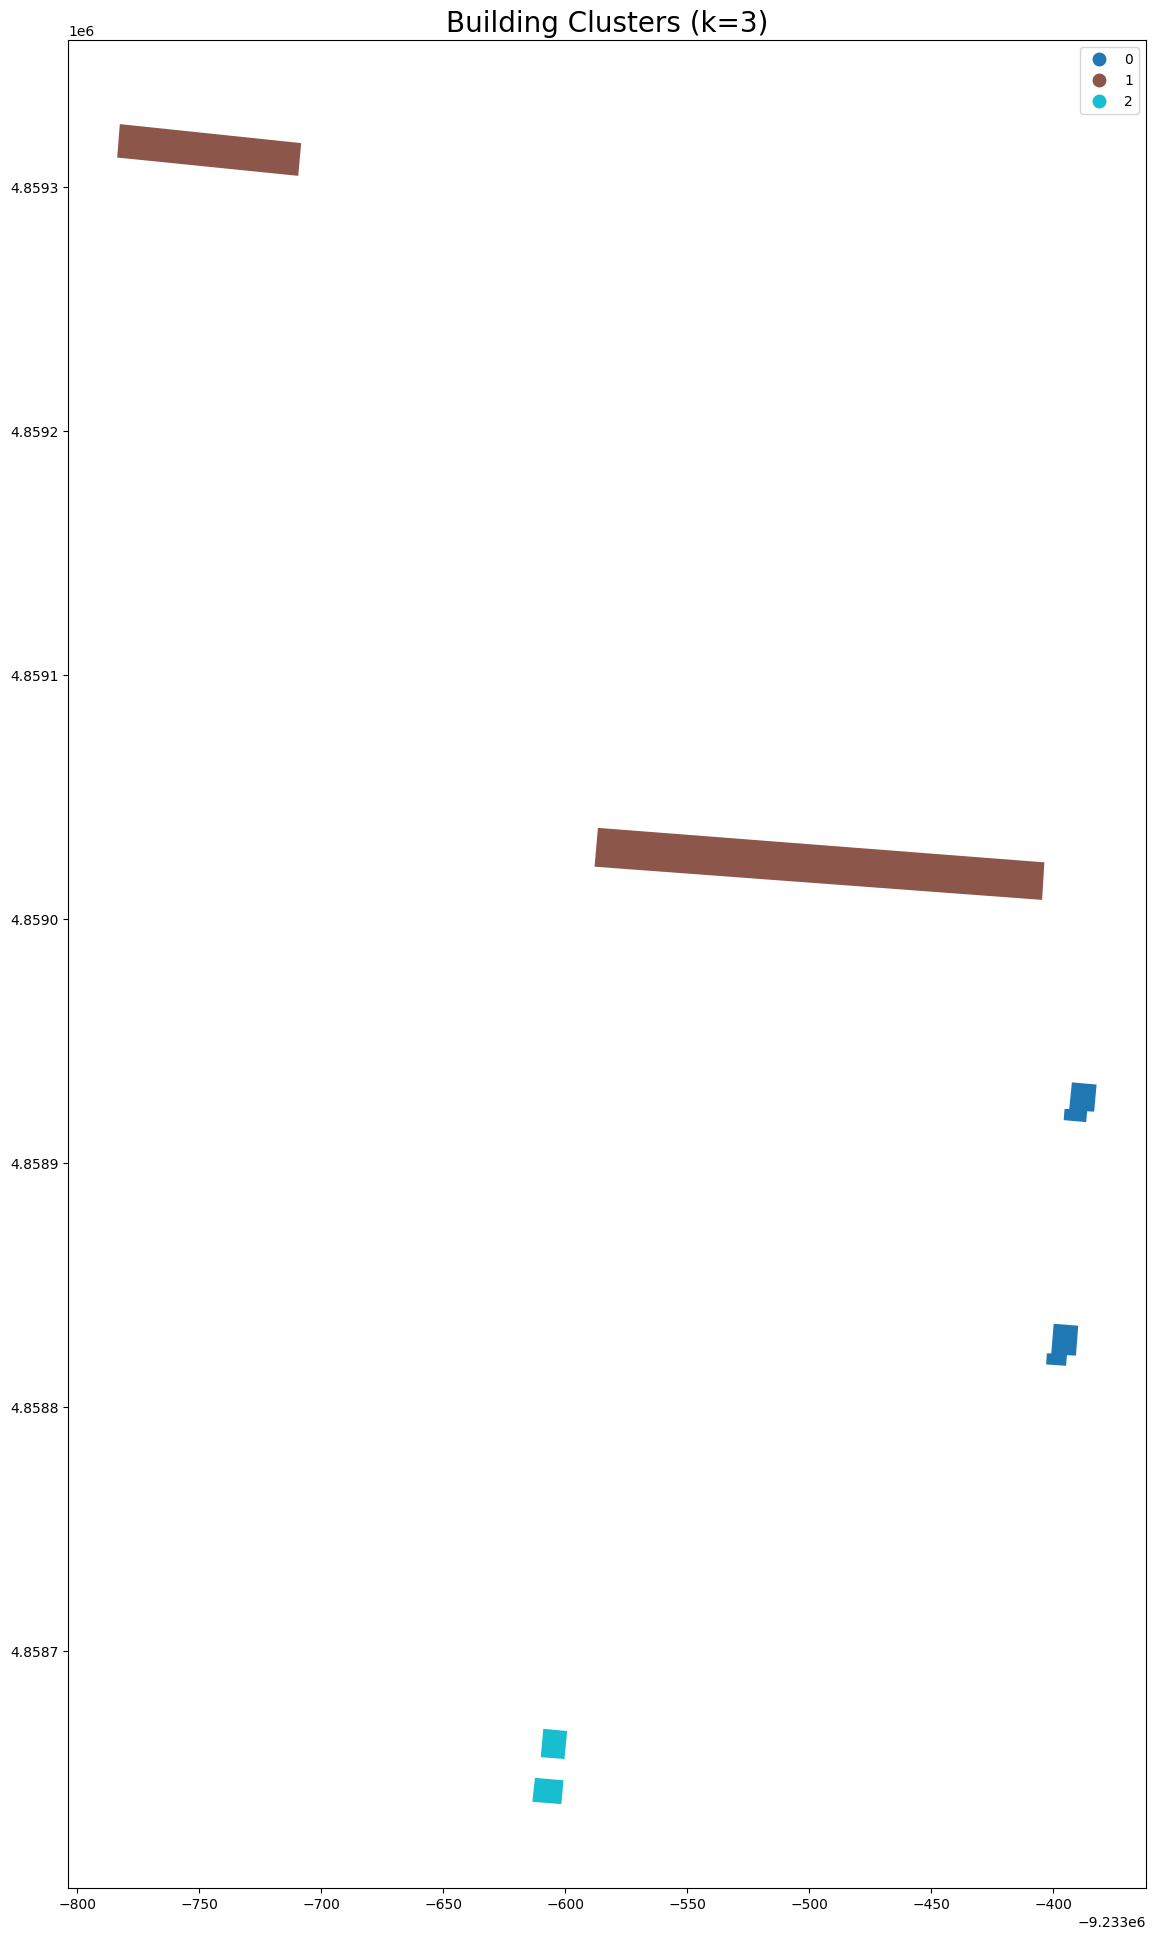

In [30]:
sub_gdf.plot(column='cluster_3', cmap='tab10', legend=True, figsize=(24,24))
plt.title("Building Clusters (k=3)", fontsize=20)

- *n*=4

In [31]:
# n = 4
clsutering_4 = SpectralClustering(n_clusters=4, affinity='precomputed', assign_labels='kmeans', random_state=0).fit(kernel_matrix)
y_pred_4 = clsutering_4.labels_.astype(int)

In [32]:
sub_gdf['cluster_4'] = y_pred_4
sub_gdf['cluster_4'] = sub_gdf['cluster_4'].astype('category') # Make the column categorical
sub_gdf

/home/summerha/.venv/lib/python3.10/site-packages/geopandas/geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,blockID,stories,materials,geometry,cluster_2,cluster_3,cluster_4
2,1869,None,concrete and cinder block,"POLYGON ((-9233783.642 4859312.213, -9233782.5...",1,1,3
151,760b,None,concrete and cinder block,"POLYGON ((-9233404.567 4859007.961, -9233587.9...",1,1,2
155,791,1.5,frame or wood,"POLYGON ((-9233395.35 4858922.309, -9233393.44...",0,0,0
183,827_b,1.5,frame or wood,"POLYGON ((-9233402.605 4858822.141, -9233400.8...",0,0,0
221,873,1.5,frame or wood,"POLYGON ((-9233608.992 4858668.227, -9233599.2...",1,2,1
224,879,1.5,frame or wood,"POLYGON ((-9233612.432 4858648.128, -9233600.7...",1,2,1


Text(0.5, 1.0, 'Building Clusters (k=4)')

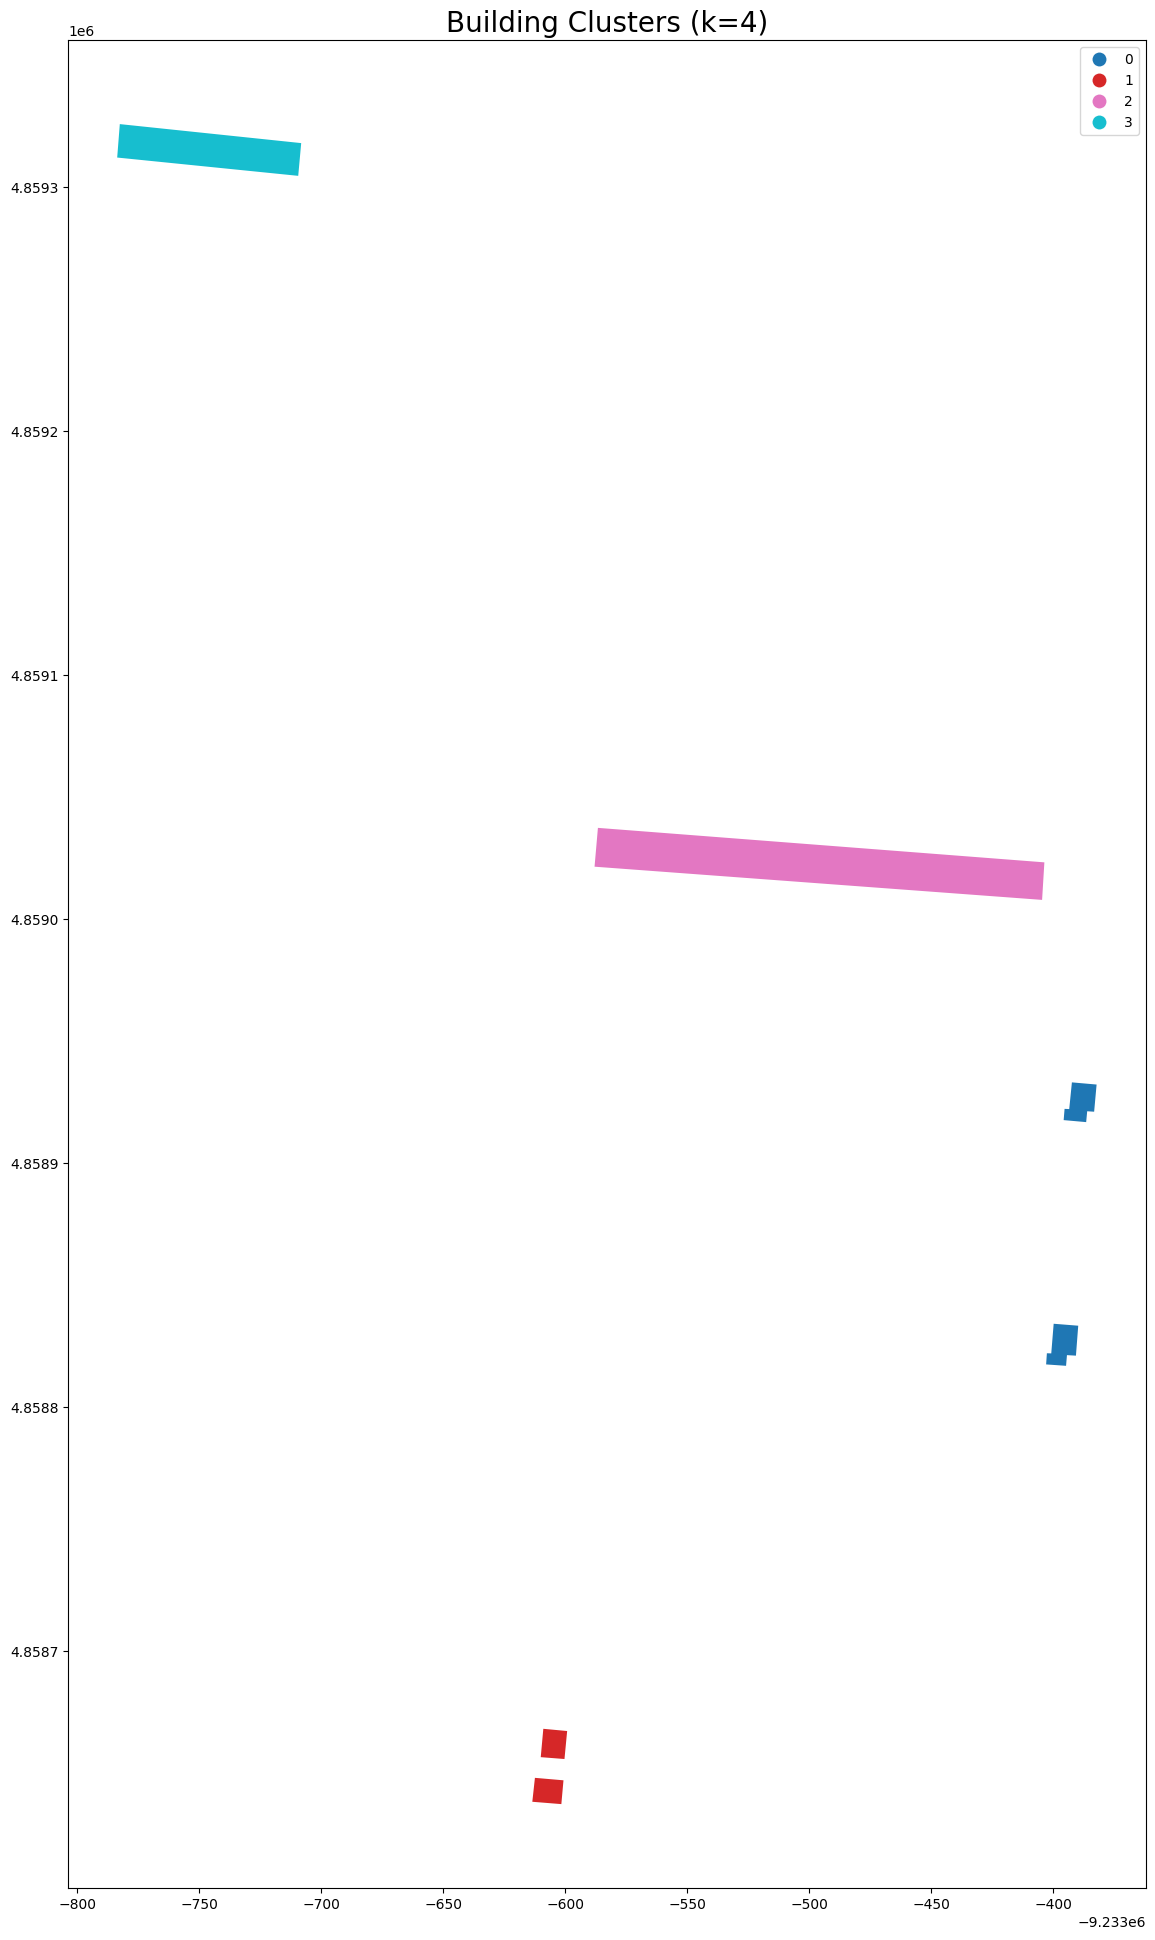

In [33]:
sub_gdf.plot(column='cluster_4', cmap='tab10', legend=True, figsize=(24,24))
plt.title("Building Clusters (k=4)", fontsize=20)